In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [3]:
# Load results of the fitting procedure

subjects = np.arange(1,9)

n_subjects = len(subjects)

# fitting_type = 'clip_RN50_best_layer_pca'
fitting_type = 'clip_RN50_all_resblocks_pca'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=True) \
       for ss in subjects]
fig_save_folder=None

skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names

areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

loading from /user_data/mmhender/imStat/model_fits/S01/clip_RN50_all_resblocks_pca/Dec-12-2021_1407_51/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'corr_each_feature', 'discrim_each_axis', 'clip_layer_name', 'clip_model_architecture', 'use_pca_clip_feats'])
loading from /user_data/mmhender/imStat/model_fits/S02/clip_RN50_all_resblocks_pca/Jan-13-2022_1121_18/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_

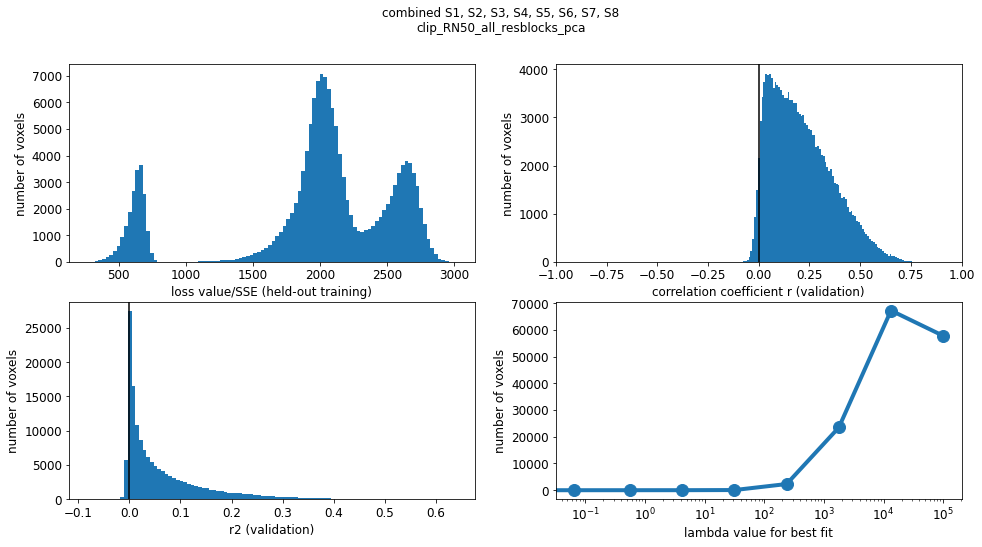

In [3]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(fitting_type, out)

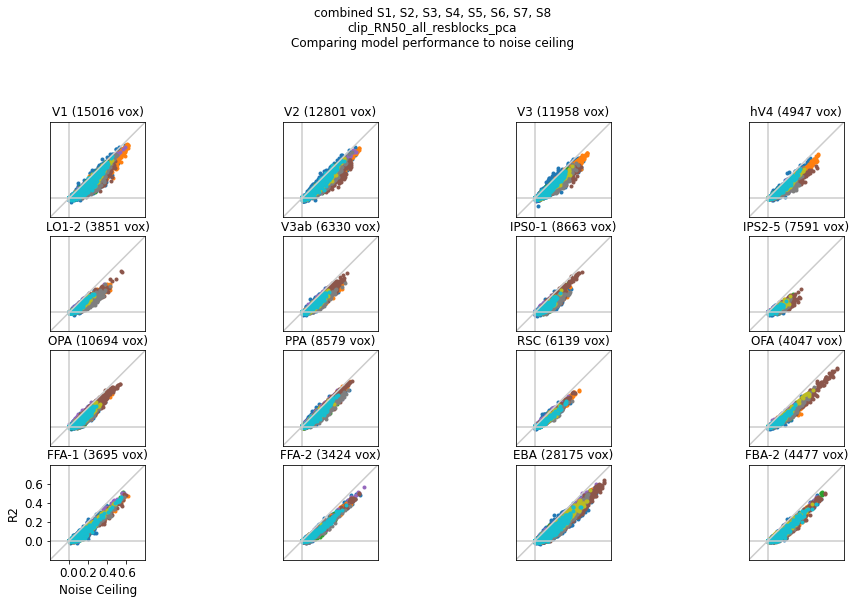

In [4]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_r2_vs_nc(fitting_type, out, roi_def=roi_def, skip_inds=None, \
                            fig_save_folder=fig_save_folder,axlims = [-0.2, 0.8])

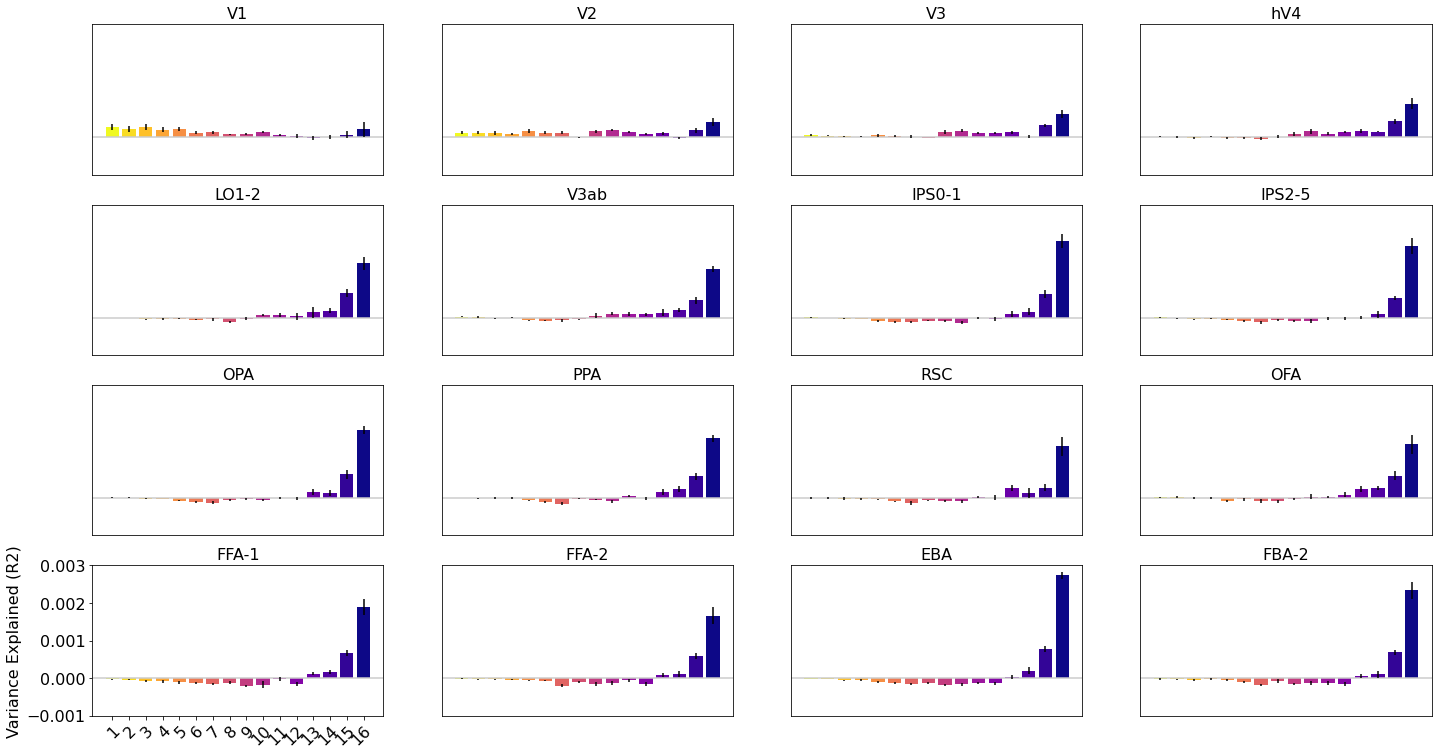

In [14]:
# Make a barplot for variance partition across all ROIs and subjects
# Mean within ROI and then over subjects, errorbars are +/- SEM across subjects

roi_names =roi_def.roi_names
n_rois = len(roi_names)

r2_thresh = 0.01

ve_names = ['%d'%(ll+1) for ll in range(16)]
leave_out_inds = np.arange(2, 33, 2)

colors = cm.plasma(np.linspace(0,1,len(leave_out_inds)))
colors = np.flipud(colors)

vals = np.zeros((n_subjects, n_rois, 16))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    var_expl = np.tile(val_r2[:,0:1], [1,16]) - val_r2[:,leave_out_inds]

    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(rr) & inds2use
        
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
       
    
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.001, 0.003])

plot_utils.set_all_font_sizes(fs = 16)
figsize=(24,20)
plt.figure(figsize=figsize)
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))
pi2label = [(npx-1)*npy+1]

pi = 0
for ri in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)
    bp.title = '%s'%(roi_names[ri])
    bp.create(mean_vals[ri,:], err_data=sem_vals[ri,:],new_fig=False, minimal_labels=(pi not in pi2label))

plt.gcf().subplots_adjust(bottom=0.4)

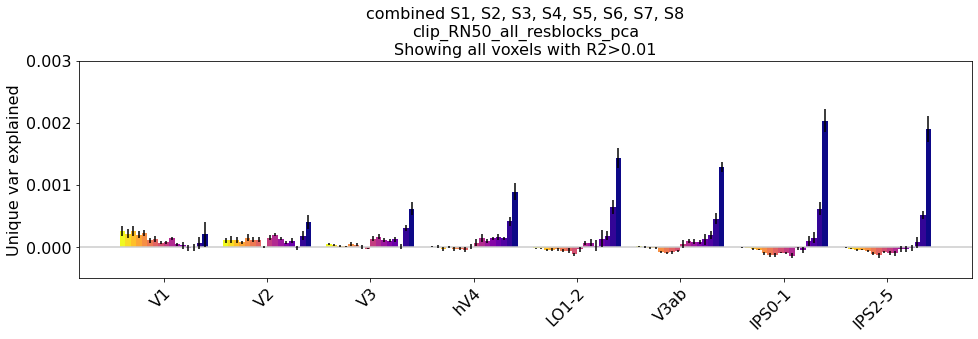

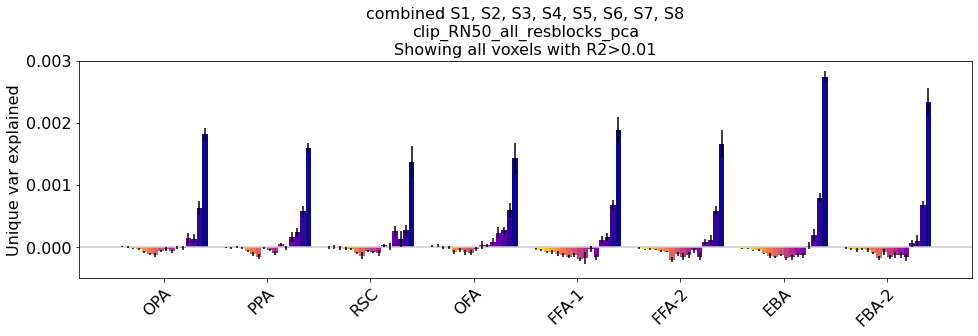

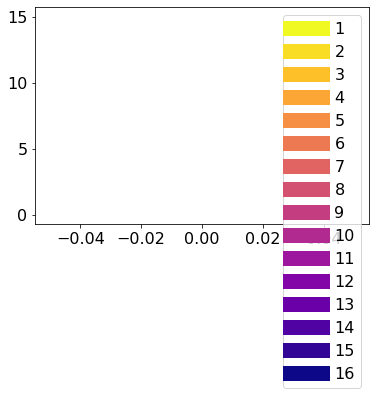

In [15]:
# Make a barplot for variance partition across all ROIs and subjects
# Mean within ROI and then over subjects, errorbars are +/- SEM across subjects

roi_names =roi_def.roi_names
n_rois = len(roi_names)

r2_thresh = 0.01

ve_names = ['%d'%(ll+1) for ll in range(16)]
leave_out_inds = np.arange(2, 33, 2)

colors = cm.plasma(np.linspace(0,1,len(leave_out_inds)))
colors = np.flipud(colors)

vals = np.zeros((n_subjects, n_rois, 16))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    var_expl = np.tile(val_r2[:,0:1], [1,16]) - val_r2[:,leave_out_inds]

    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(rr) & inds2use
        
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
       
    
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)


plot_utils.set_all_font_sizes(fs = 16)
for ii, inds in enumerate([np.arange(0,8),np.arange(8,16)]):

    legend_separate = (ii==1)
        
    plot_utils.plot_multi_bars(mean_data=mean_vals[inds,:], err_data=sem_vals[inds,:], colors=colors, space=0.10, \
                    xticklabels=np.array(roi_names)[inds], ylabel='Unique var explained', \
                    ylim=[-0.0005, 0.00300], title=title, horizontal_line_pos=0,\
                    legend_labels=ve_names, \
                    legend_overlaid=False, legend_separate=legend_separate, \
                    fig_size=(16,4))

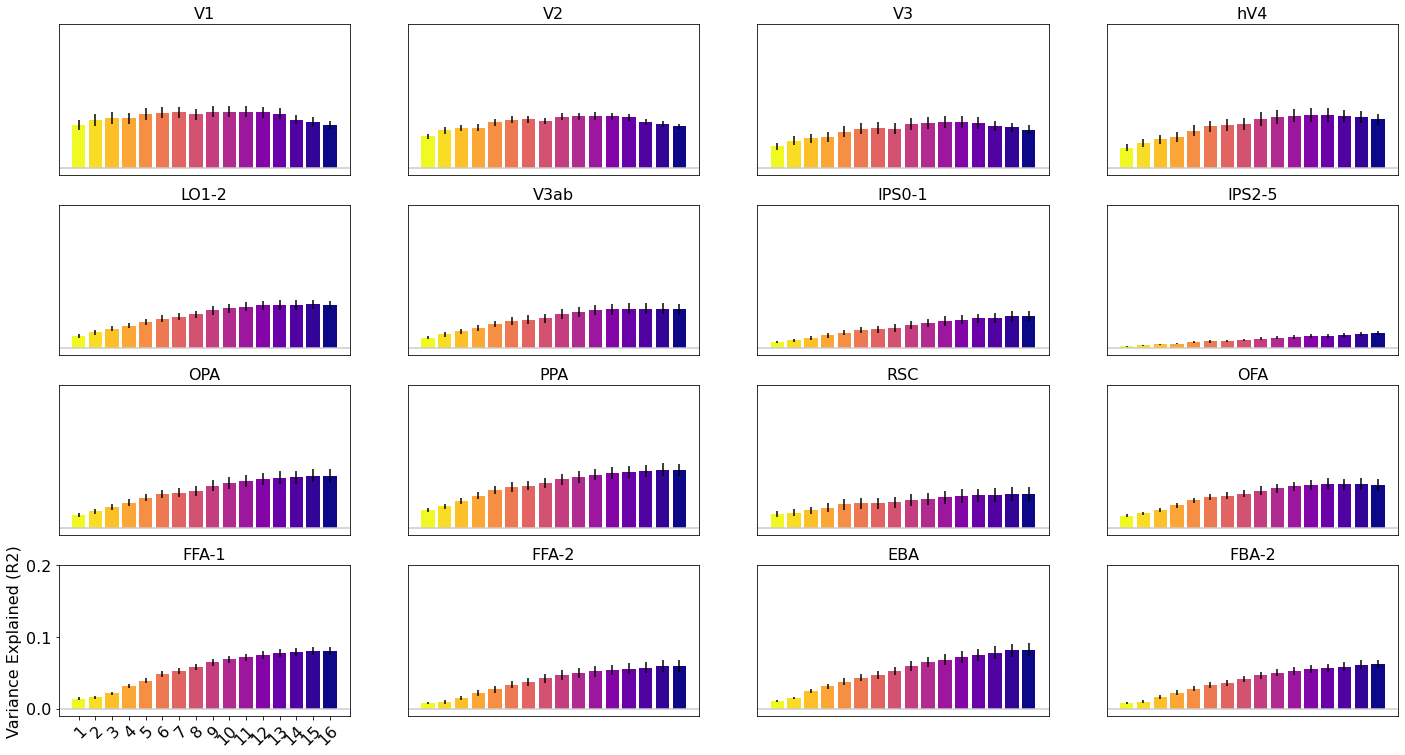

In [16]:
# Make a barplot for variance partition across all ROIs and subjects
# Mean within ROI and then over subjects, errorbars are +/- SEM across subjects

roi_names =roi_def.roi_names
n_rois = len(roi_names)

inds = np.arange(1, 33, 2)
names = [out[0]['partial_version_names'][ii].split('just_clip_block')[1] for ii in inds]

colors = cm.plasma(np.linspace(0,1,len(inds)))
colors = np.flipud(colors)

vals = np.zeros((n_subjects, n_rois, 16))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    r2 = val_r2[:,inds]
    
    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(rr)
        
        vals[si,ri,:] = np.mean(r2[inds_this_roi,:], axis=0)
       
    
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.20])

plot_utils.set_all_font_sizes(fs = 16)
figsize=(24,20)
plt.figure(figsize=figsize)
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))
pi2label = [(npx-1)*npy+1]

pi = 0
for ri in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)
    bp.title = '%s'%(roi_names[ri])
    bp.create(mean_vals[ri,:], err_data=sem_vals[ri,:],new_fig=False, minimal_labels=(pi not in pi2label))

plt.gcf().subplots_adjust(bottom=0.4)

In [19]:
# Make plots in pycortex for variance partitioning analysis
# Full variance partition over all subsets

import cortex
from utils import numpy_utils
from plotting import pycortex_plot_utils

port=44442

title = 'CLIP all, %s'%(summary_plots.get_substr(out));

names = []
maps = []
cmaps = []
mins = []
maxes = []
vox2plot = []
subject_map_inds = []
map_sequence = []

for si, ss in enumerate(subjects):

    names += ['S%d: all layers concat (sqrt R2)'%ss]
    maps += [np.sqrt(out[si]['val_r2'][:,0])]
    cmaps += ['PuBu']
    mins += [0]
    maxes += [0.60]

    ff_inds = np.arange(2, 33, 2)
    n_submodels = len(ff_inds)

    val_r2 = out[si]['val_r2']
    var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_submodels]) - val_r2[:,ff_inds] 
    ve_names = ['Unique: ' + out[si]['partial_version_names'][ff].split('leave_out_')[1] \
                                 for ff in ff_inds]
    ve_names = ['S%d: '%ss + vn for vn in ve_names]
    names += ve_names
    maps += [np.sqrt(var_expl[:,ff]) for ff in range(n_submodels)]
    cmaps += ['PuBu' for ff in range(n_submodels)]
    mins += [0 for ff in range(n_submodels)]
    maxes += [0.2 for ff in range(n_submodels)]
    
    names += ['S%d: Preferred feature type (max unique var)'%ss]
    maps += [np.argmax(var_expl, axis=1).astype(np.float32)]
    cmaps += ['plasma_r']
    mins += [0]
    maxes += [n_submodels+1]
    
    inds = np.arange(1, 33, 2)
    indiv_var = val_r2[:,inds]
    names += ['S%d: Preferred feature type (R2 individually var)'%ss]
    maps += [np.argmax(indiv_var, axis=1).astype(np.float32)]
    cmaps += ['plasma_r']
    mins += [0]
    maxes += [n_submodels+1]

    vox2plot.append(out[si]['val_r2'][:,0]>0.01)
    
    n_new_maps = int(len(names)/(si+1))
    subject_map_inds += [si for ii in range(n_new_maps)]
    map_sequence += [ni for ni in range(n_new_maps)]
    
# putting them into a nicer order (want same type of map near each other to compare subs)
_, new_order = numpy_utils.double_sort(np.arange(len(maps)), map_sequence, subject_map_inds)
names = [names[ni] for ni in new_order]
cmaps = [cmaps[ni] for ni in new_order]
mins = [mins[ni] for ni in new_order]
maxes = [maxes[ni] for ni in new_order]
maps = [maps[ni] for ni in new_order]
subject_map_inds = [subject_map_inds[ni] for ni in new_order]



voxel_mask = [o['voxel_mask'] for o in out]
nii_shape = [o['brain_nii_shape'] for o in out]
volume_space = out[0]['volume_space']

pycortex_plot_utils.plot_maps_pycortex(subjects, port, maps, names, subject_map_inds=subject_map_inds, \
                        mins=mins, maxes=maxes, cmaps=cmaps, \
                        title=title, vox2plot = vox2plot, roi_def=None, \
                        voxel_mask =voxel_mask, \
                        nii_shape = nii_shape, \
                        volume_space=volume_space)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


navigate browser to: 127.0.0.1:44442
Started server on port 44442


<JS: window.viewer>

Stopping server
